In [1]:
from monty.serialization import loadfn, dumpfn
from pymatgen import Structure, Composition, Element
from pymatgen.entries.computed_entries import ComputedEntry, ComputedStructureEntry
from pymatgen.analysis.structure_matcher import StructureMatcher, ElementComparator
from pymatgen.entries.entry_tools import EntrySet
from pymatgen.util.plotting import periodic_table_heatmap
from itertools import groupby
from re import sub

In [2]:
scan_entries = loadfn('element_scan_entries_2020-04-09.json')
gga_entries = loadfn('element_gga_entries_2020-03-10.json')

def sort_by_element(entries_list):
    elem_dict = dict()
    for entry in entries_list:
        element = sub(r'[0-9]', '', entry.structure.composition.reduced_formula)
        if not element in elem_dict.keys():
            elem_dict[element] = list([entry])
        else:
            elem_dict[element].append(entry)
    return elem_dict

#Dictionaries where keys are elements and values are lists of entries associated with each element
scan_sorted, gga_sorted = sort_by_element(scan_entries), sort_by_element(gga_entries)

#What elements are missing from scan?
missing_from_scan = list()
for elem in gga_sorted.keys():
    if elem not in scan_sorted.keys():
        missing_from_scan.append(elem)

/home/ayush/miniconda3/envs/scan/lib/python3.8/site-packages/pymatgen/core/periodic_table.py:423: UserWarning: No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn("No electronegativity for %s. Setting to NaN. "
/home/ayush/miniconda3/envs/scan/lib/python3.8/site-packages/pymatgen/core/periodic_table.py:423: UserWarning: No electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn("No electronegativity for %s. Setting to NaN. "
/home/ayush/miniconda3/envs/scan/lib/python3.8/site-packages/pymatgen/core/periodic_table.py:423: UserWarning: No electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  warnings.warn("No electronegativity for %s. Setting to NaN. "


In [3]:
def get_ground_state(entries_dict):
    gs_dict = dict()
    for element in entries_dict.keys():
        entry_set = EntrySet(entries_dict[element])
        entry_set.remove_non_ground_states()
        gs_dict[element] = list(entry_set)[0]
    return gs_dict

#Key: element, Value: entry corresponding to ground state structure
scan_gs_dict, gga_gs_dict = get_ground_state(scan_sorted), get_ground_state(gga_sorted)

In [4]:
matcher = StructureMatcher(primitive_cell=True, 
                      scale=True, 
                      attempt_supercell=False, 
                      allow_subset=False, 
                      comparator=ElementComparator())

#Key: element, Value: tuple with SCAN & GGA entries of elements with different ground states for SCAN & GGA
def get_diff_dict(scan_gs_dict, gga_gs_dict):
    diff_dict = dict()
    for element in scan_gs_dict.keys():
        scan_struct, gga_struct = scan_gs_dict[element].structure, gga_gs_dict[element].structure
        if not matcher.fit(scan_struct, gga_struct):
            diff_dict[element] = (scan_gs_dict[element], gga_gs_dict[element])
    return diff_dict

diff_dict = get_diff_dict(scan_gs_dict, gga_gs_dict)
diff_dict

{'Al': (ComputedStructureEntry 6676 - Al4
  Energy = -30.9765
  Correction = 0.0000
  Parameters:
  run_type = SCAN
  potcar_spec = [{'titel': 'PAW_PBE Al 04Jan2001', 'hash': '9aafba2c552fad8414179cae2e888e67'}]
  is_hubbard = False
  hubbards = {}
  pseudo_potential = {'functional': 'pbe', 'pot_type': 'paw', 'labels': ['Al']}
  Data:,
  ComputedStructureEntry mp-134 - Al1
  Energy = -3.7481
  Correction = 0.0000
  Parameters:
  run_type = GGA
  potcar_spec = [{'titel': 'PAW_PBE Al 04Jan2001', 'hash': 'a6fd9a46aec185f4ad2acd0cbe4ae2fa'}]
  is_hubbard = False
  hubbards = {}
  pseudo_potential = {'functional': 'pbe', 'pot_type': 'paw', 'labels': ['Al']}
  Data:),
 'Ar': (ComputedStructureEntry 4460 - Ar2
  Energy = -13.8764
  Correction = 0.0000
  Parameters:
  run_type = SCAN
  potcar_spec = [{'titel': 'PAW_PBE Ar 07Sep2000', 'hash': '5a1c16df019650eae101e4540ab17187'}]
  is_hubbard = False
  hubbards = {}
  pseudo_potential = {'functional': 'pbe', 'pot_type': 'paw', 'labels': ['Ar']}


In [5]:
#Key: element, value: difference in energy_per_atom of SCAN and GGA ground state structures
energy_dict = dict()
for elem in diff_dict.keys():
    energy_dict[elem] = diff_dict[elem][0].energy_per_atom - diff_dict[elem][1].energy_per_atom
energy_dict

{'Al': -3.9960331875,
 'Ar': -6.869397960000001,
 'As': -15.5425461175,
 'Au': -65.90934114000001,
 'C': -0.8857170137499999,
 'Co': -10.19596735,
 'Cs': -37.1339846962069,
 'F': -1.66627729,
 'H': -0.06350073000000034,
 'Hg': -67.88475623333333,
 'Ho': -44.43455031166666,
 'In': -30.57999817583334,
 'K': -7.233657096750001,
 'Li': -0.49340315999999973,
 'Mg': -3.3904084899999996,
 'Mn': -8.873988119999998,
 'N': -0.9795600237499986,
 'Na': -2.8852360045000003,
 'O': -1.3213078612500002,
 'P': -5.0017816701190485,
 'Pa': -90.173013,
 'Pr': -38.5574730575,
 'Rb': -19.73385955534483,
 'S': -5.513049360625001,
 'Sb': -33.145890485,
 'Se': -16.614007935260418,
 'Tc': -24.7053186675,
 'Tl': -70.002064635,
 'Tm': -47.36899828666666,
 'Xe': -36.22010858,
 'Yb': -48.99563119}

Elements (31): ['Al', 'Ar', 'As', 'Au', 'C', 'Co', 'Cs', 'F', 'H', 'Hg', 'Ho', 'In', 'K', 'Li', 'Mg', 'Mn', 'N', 'Na', 'O', 'P', 'Pa', 'Pr', 'Rb', 'S', 'Sb', 'Se', 'Tc', 'Tl', 'Tm', 'Xe', 'Yb']


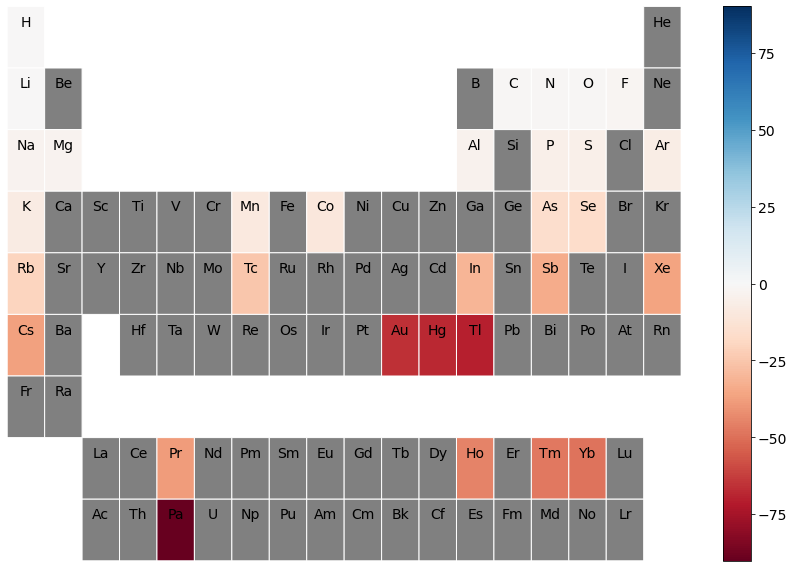

<module 'matplotlib.pyplot' from '/home/ayush/miniconda3/envs/scan/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [6]:
#display periodic table heatmap using energy_dict
keys = list(energy_dict.keys())
print('Elements ({0}):'.format(len(keys)), keys)
maxval = max([abs(e) for e in energy_dict.values()]) #used to center color scale at 0
periodic_table_heatmap(energy_dict, show_plot=True, cmap='RdBu', cmap_range=(-maxval, maxval))

In [7]:
missing_from_scan

['He']

In [8]:
#Find unstable GGA polymorph that is SCAN ground state, and vice-versa
#gs_energy_diff (dictionary) --> contains the calculation as specified by email
#problematic_elements --> ones that are giving a bit of trouble

gs_energy_diff = dict()
problematic_elements = list()

for elem in diff_dict.keys():
    scan_gs = scan_gs_dict[elem]
    gga_gs = gga_gs_dict[elem]
    
    matching_in_gga = None
    matching_in_scan = None
    
    for entry in gga_sorted[elem]:
        if matcher.fit(scan_gs.structure, entry.structure):
            matching_in_gga = entry
            break
            
    for entry in scan_sorted[elem]:
        if matcher.fit(gga_gs.structure, entry.structure):
            matching_in_scan = entry
            break
            
    if matching_in_gga and matching_in_scan:
        gs_energy_diff[elem] = (scan_gs.energy_per_atom - matching_in_scan.energy_per_atom) - (matching_in_gga.energy_per_atom - gga_gs.energy_per_atom)
    else:
        problematic_elements.append((elem, True if matching_in_gga else False, True if matching_in_scan else False))

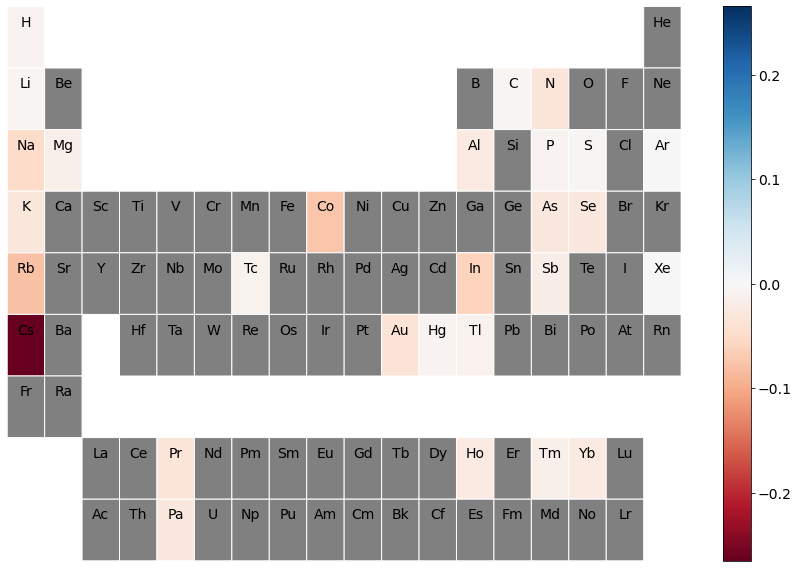

<module 'matplotlib.pyplot' from '/home/ayush/miniconda3/envs/scan/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [9]:
'''
gs_energy_diff is a dict
key = element
value:
(energy_per_atom of the SCAN ground state minus energy_per_atom of the unstable SCAN polymorph that is also the GGA ground state)
minus
(energy_per_atom of the unstable GGA polymorph that is also the SCAN ground state minus energy_per_atom of GGA ground state)

--->matching done with StructureMatcher
'''

maxval1 = max([abs(e) for e in gs_energy_diff.values()]) #used to center color scale at 0
periodic_table_heatmap(gs_energy_diff, show_plot=True, cmap='RdBu', cmap_range=(-maxval1, maxval1))

In [10]:
problematic_elements

[('F', True, False), ('Mn', True, False), ('O', False, False)]

In [11]:
#writes ground state structures to cif files in working directory
def write_to_cif(elem, scan_structs, gga_structs):
    i = 0
    for struct in scan_structs:
        struct.to(fmt=".cif", filename='special_cif/{0}/scan/{1}_{2}_scan.cif'.format(elem, struct.composition.reduced_formula, i))
        i += 1
    i = 0
    for struct in gga_structs:
        struct.to(fmt=".cif", filename='special_cif/{0}/gga/{1}_{2}_gga.cif'.format(elem, struct.composition.reduced_formula, i))
        i += 1

In [17]:
fs, fg = sorted(scan_sorted['F'], key=lambda x: x.energy_per_atom), sorted(gga_sorted['F'], key=lambda x: x.energy_per_atom)
mns, mng = sorted(scan_sorted['Mn'], key=lambda x: x.energy_per_atom), sorted(gga_sorted['Mn'], key=lambda x: x.energy_per_atom)

In [20]:
write_to_cif('F', [e.structure for e in fs], [e.structure for e in fg])
write_to_cif('Mn', [e.structure for e in mns], [e.structure for e in mng])